<h1> MIDS W207 Final</h1>

<h3> Group Members </h3>
Ben Attix <br>
Justin Plumley <br>
Dan Watson

<h3> Kaggle Competition </h3>
Zillow Prize: Zillow’s Home Value Prediction (Zestimate)

<h3> Evaluation </h3>
Submissions are evaluated on Mean Absolute Error between the predicted log error and the actual log error. The log error is defined as:
logerror=log(Zestimate)−log(SalePrice)
and it is recorded in the transactions training data. If a transaction didn't happen for a property during that period of time, that row is ignored and not counted in the calculation of MAE.

<h5> Competition Website </h5>
https://www.kaggle.com/c/zillow-prize-1#description

<h2> Load libraries, data, and test output

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

#ignore warnings- deprecation issues w/ packages
import warnings
warnings.filterwarnings('ignore')

# General libraries.
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
import time
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D


# SK-learn libraries for learning.
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 


# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_csv = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
prop_df = pd.read_csv("properties_2016.csv")
print(prop_df.shape)
print(train_csv.shape)
#df outputs
#prop_df.head()
#train_df.head()

(2985217, 58)
(90275, 3)


In [3]:
train_csv.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


<H2> EDA </H2> <br>
Many ideas and code taken from following EDA Kernels:
https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize (python)
https://www.kaggle.com/philippsp/exploratory-analysis-zillow (R)
https://www.kaggle.com/captcalculator/a-very-extensive-zillow-exploratory-analysis (R)
https://www.kaggle.com/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity (python)

<H5> Start by looking at the parcelIDs that occur in each dataset </H5>

In [4]:
# start by looing at unique parcelIDs
print("Unique ParcelIDs in train_df:", train_csv.parcelid.nunique())
print("Unique ParcelIDs in prop_df:", prop_df.parcelid.nunique())

('Unique ParcelIDs in train_df:', 90150)
('Unique ParcelIDs in prop_df:', 2985217)


We have 2,985,217 parcel IDs in the properties data but only 90,150 in the training data. When training our model, the only parcel IDs we can use are the ones both datasets, the rest are useless to us.

By doing an inner merge we can limit our data down to the parcel IDs we want.

In [5]:
# merge dataframes and view result
train_df = pd.merge(train_csv, prop_df, on='parcelid', how='inner')
print('Dataframe shape:', train_df.shape)
train_df.head()

('Dataframe shape:', (90275, 60))


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [6]:
train_df.describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,9.027500e+04,90275.000000,28781.000000,261.000000,43.000000,90275.000000,90275.000000,16.0,57364.000000,89093.000000,...,95.000000,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,1783.000000,8.967000e+04
mean,1.298466e+07,0.011457,1.816372,7.229885,713.581395,2.279474,3.031869,4.0,5.565407,2.309216,...,311.694737,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,13.402692,6.049151e+13
std,2.504510e+06,0.161079,2.974168,2.716196,437.434198,1.004271,1.156436,0.0,1.900602,0.976172,...,346.354850,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,2.715966,2.046605e+11
min,1.071174e+07,-4.605000,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,...,18.000000,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.000000,6.037101e+13
25%,1.155950e+07,-0.025300,1.000000,7.000000,407.500000,2.000000,2.000000,4.0,4.000000,2.000000,...,100.000000,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,13.000000,6.037320e+13
50%,1.254734e+07,0.006000,1.000000,7.000000,616.000000,2.000000,3.000000,4.0,7.000000,2.000000,...,159.000000,1970.000000,1.000000,1.320000e+05,3.428720e+05,2015.0,1.929700e+05,4542.750000,14.000000,6.037615e+13
75%,1.422755e+07,0.039200,1.000000,7.000000,872.000000,3.000000,4.000000,4.0,7.000000,3.000000,...,361.000000,1987.000000,2.000000,2.105345e+05,5.405890e+05,2015.0,3.454195e+05,6901.090000,15.000000,6.059042e+13
max,1.629608e+08,4.737000,13.000000,21.000000,1555.000000,20.000000,16.000000,4.0,12.000000,20.000000,...,1366.000000,2015.000000,4.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,99.000000,6.111009e+13


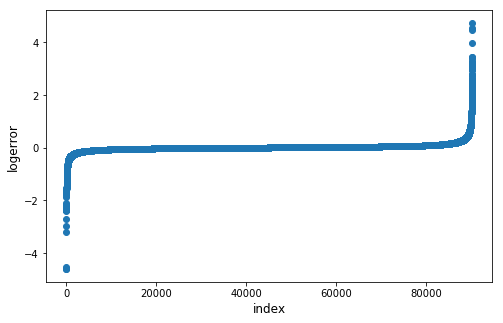

In [7]:
# View ordered scatter of log errors
plt.figure(figsize=(8,5))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

Log error is quite good for vast majority.  Seem like most are very close to zero with relatively large errors at the extremes.

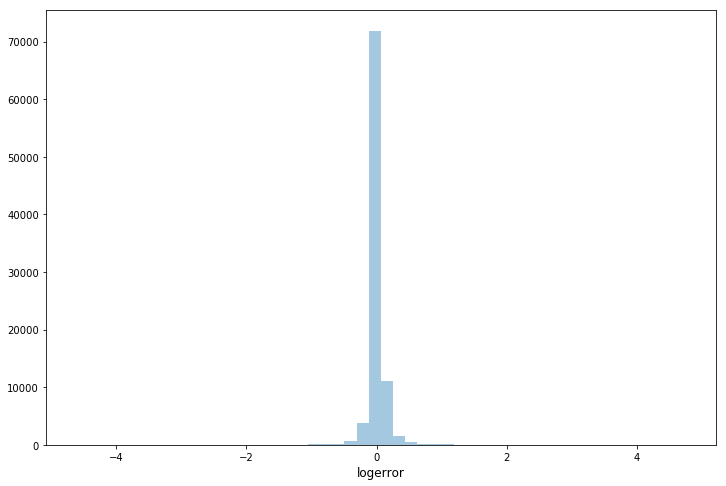

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Similar to above, very peaked distribution centered around 0 log error.  Very low outliers in number, but large in relative scale.

<H5> Transaction Date </H5>

In [9]:
train_df.transactiondate.describe()

count                   90275
unique                    352
top       2016-07-29 00:00:00
freq                      910
first     2016-01-01 00:00:00
last      2016-12-30 00:00:00
Name: transactiondate, dtype: object

All the data is from 2016- we can aggregate it by month

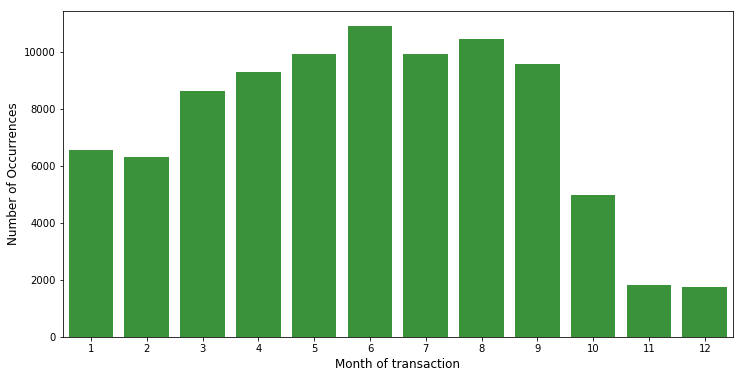

In [10]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
bars= sns.barplot(cnt_srs.index, cnt_srs.values,  color=color[2])
plt.xticks()
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

Slow start of the year, then transactions pick up through August.  We do not have all the transactions after October 15th, per competition website.

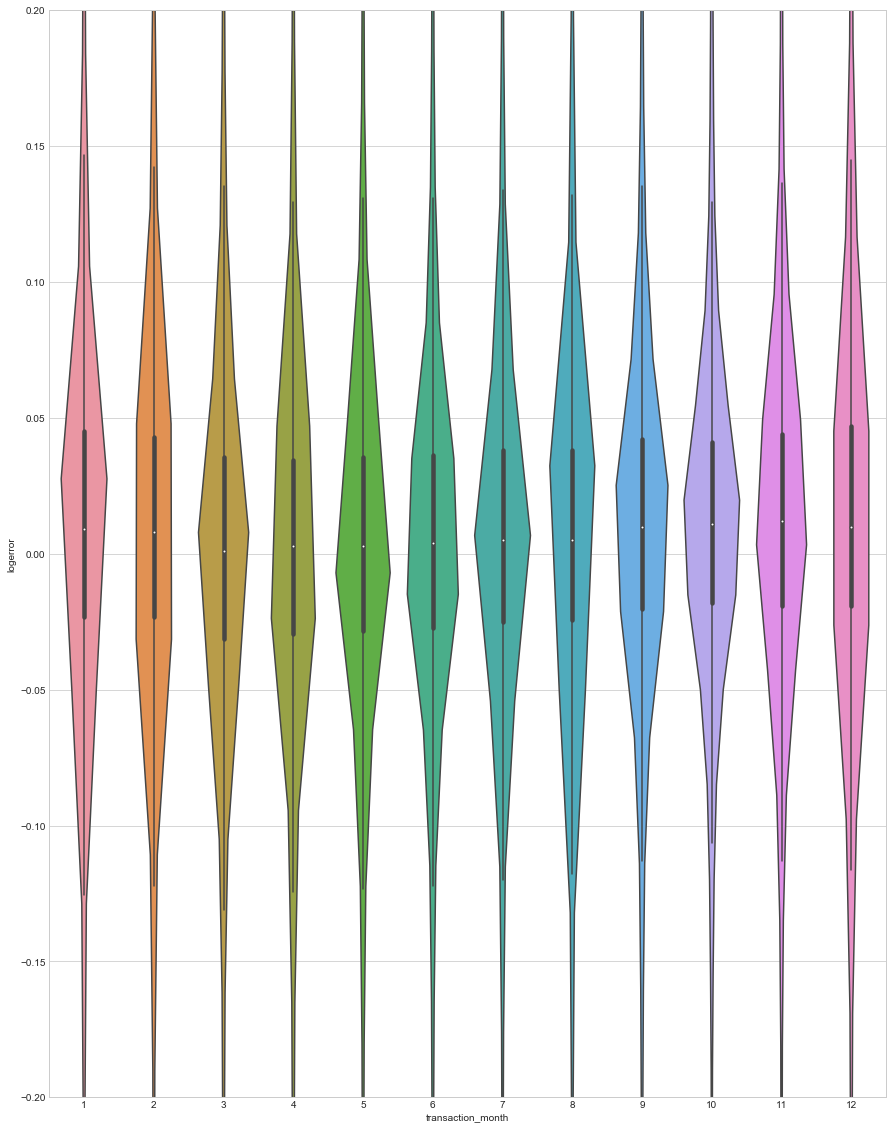

In [11]:
## Create violin plots to visualize range and variance of logerror by month
sns.set_style("whitegrid")
s1_dims = (15, 20)
fig, ax = plt.subplots(figsize=s1_dims)
ax.set(ylim=(-0.2, 0.2))
sns.violinplot(ax=ax, data=train_df, x="transaction_month", y="logerror")

Variance appears to grow with the later months (those with fewer values), though the medians appear to be positive, particularly for the winter months.  Besides normal features, we may want to include dummy variables for seasonality.


## More on Large Log Errors

This competition is focused on predicting the log error of predicted versus transaction prices. As shown in the graph in EDA section and recreated below, the vast majority of log errors are quite low. It is in the extreme values where the error rates increase drastically. Therefore, we will perform an analysis on just these extreme values to see if there are any patterns that will help us identify these values.


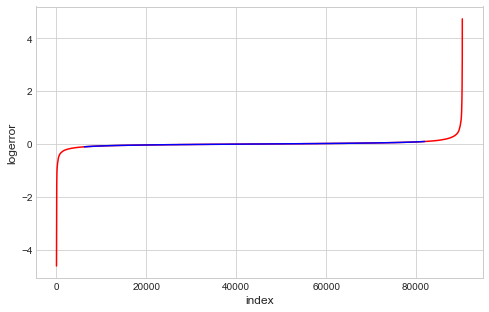

In [13]:
plt.figure(figsize=(8,5))
# create a mask for values less than -.1 and greater than .1
masked = np.ma.masked_outside(np.sort(train_df.logerror.values), -.1, .1)
# plot masked and non-masked values
plt.plot(range(train_df.shape[0]), np.sort(train_df.logerror.values), 'red')
plt.plot(range(train_df.shape[0]), masked, 'blue')
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [14]:
high_error_df= train_df[(train_df.logerror <-.1) | (train_df.logerror >.1)]
low_error_df = train_df[(train_df.logerror>=-.1) & (train_df.logerror<=.1)]

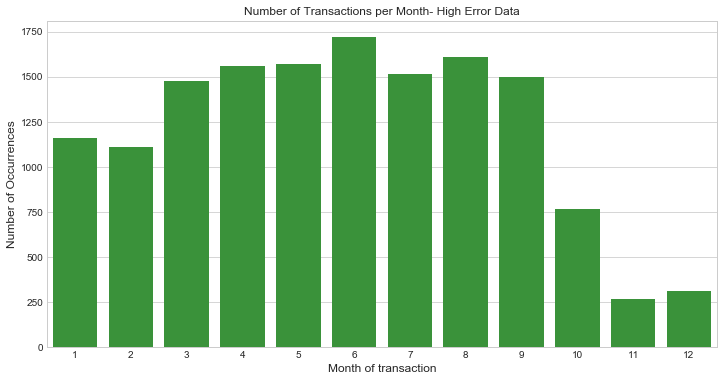

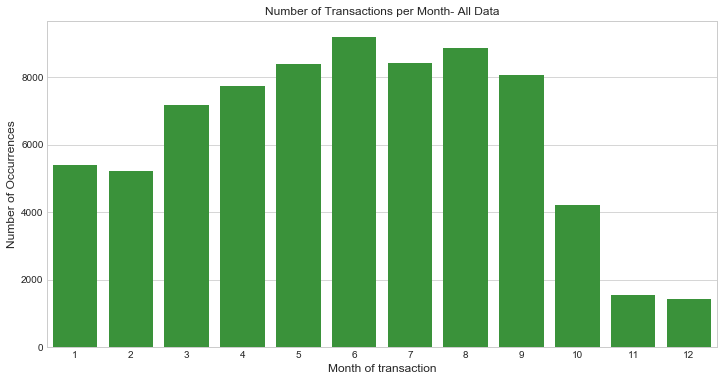

In [15]:
cnt_srs = high_error_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
bars= sns.barplot(cnt_srs.index, cnt_srs.values,  color=color[2])
plt.xticks()
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Number of Transactions per Month- High Error Data')
plt.show()



cnt_srs = low_error_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
bars= sns.barplot(cnt_srs.index, cnt_srs.values,  color=color[2])
plt.xticks()
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Number of Transactions per Month- All Data')
plt.show()

In [16]:
#Cycle through the column indxes of the next two cells to compare the descriptive statistics
#between the high error and the low error transactions
high_error_df.ix[:, 0:10].describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid
count,1.457500e+04,14575.000000,3941.000000,26.000000,10.00000,14575.000000,14575.000000,13.0,10394.000000
mean,1.269726e+07,0.050639,1.587668,7.269231,770.60000,2.281990,3.063945,4.0,5.863575
std,2.059733e+06,0.387913,2.561674,3.079710,510.46715,1.244034,1.379942,0.0,1.962375
min,1.071180e+07,-4.605000,1.000000,2.000000,184.00000,0.000000,0.000000,4.0,1.000000
25%,1.156110e+07,-0.148500,1.000000,7.000000,369.00000,1.500000,2.000000,4.0,4.000000
50%,1.218885e+07,0.112400,1.000000,7.000000,653.00000,2.000000,3.000000,4.0,7.000000
75%,1.387711e+07,0.193900,1.000000,7.000000,1111.00000,3.000000,4.000000,4.0,7.000000
max,1.629604e+08,4.737000,13.000000,21.000000,1555.00000,15.000000,16.000000,4.0,12.000000


In [17]:
low_error_df.ix[:, 0:10].describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid
count,7.570000e+04,75700.000000,24840.000000,235.000000,33.000000,75700.000000,75700.000000,3.0,46970.000000
mean,1.303999e+07,0.003913,1.852657,7.225532,696.303030,2.278989,3.025694,4.0,5.499425
std,2.577699e+06,0.040238,3.032924,2.680291,420.159604,0.951204,1.108144,0.0,1.880302
min,1.071174e+07,-0.099800,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000
25%,1.155898e+07,-0.021200,1.000000,7.000000,485.000000,2.000000,2.000000,4.0,4.000000
50%,1.262386e+07,0.004000,1.000000,7.000000,608.000000,2.000000,3.000000,4.0,7.000000
75%,1.428257e+07,0.029600,1.000000,7.000000,831.000000,3.000000,4.000000,4.0,7.000000
max,1.629608e+08,0.099800,13.000000,21.000000,1528.000000,20.000000,16.000000,4.0,12.000000


Reviewing the differences in the high errors and low errors dataframes, we observe the following differences:

__Calculated Finished Square Feet:__ The low error transactions have a mean value of 1739 sqft with a standard deviation of 876sqft.  The high error transactions have a high mean value of 1870 sqft with a higher standard deviation of 1197. 

<b> Structure Tax Value Dollar Count </b> The high error transactions have a higher mean (192253 vs 176848) and a higher standard deviation (310239 vs 183111) than low error transactions.

<b> Land Tax Value Dollar Count </b> Similar to the structure tax value dollar count, the mean land value dollar count is higher for high error transactions (322560 vs 269816) and has a higher standard deviation (641348 vs 334122).

<b> FIPS </b> The FIPS indicates the county of the home.  In the high error data, 73.8% of the homes are in Los Angeles County, 19% are in Orange County, and 6.7% are in Ventura County.  In the low error data, 63% are in Los Angeles County, 28% are in Orange County, and 8.2% are in Ventura County.

<H3> Onto the Properties 2016 file <H3>

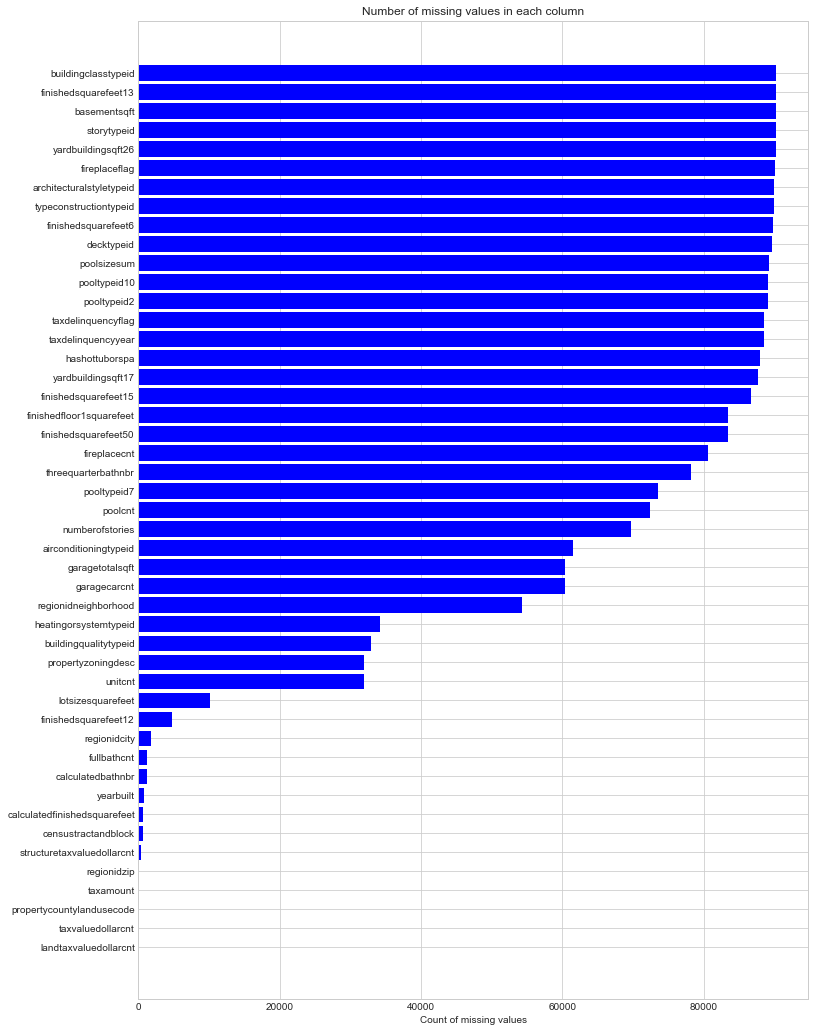

In [18]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [19]:
# How much of your data is missing?
train_df.isnull().sum().sort_values(ascending=False).head()

buildingclasstypeid     90259
finishedsquarefeet13    90242
basementsqft            90232
storytypeid             90232
yardbuildingsqft26      90180
dtype: int64

## Data Cleanup

Our dataset is extremely sparse for many variables and also contains categorical variables that need to be transformed.  The following code makes those transformations.

In [20]:
# df = df.drop('column_name', 1)
to_drop = ['architecturalstyletypeid'
           ,'assessmentyear'
           ,'bathroomcnt'
           ,'buildingclasstypeid'
           ,'decktypeid'
           ,'threequarterbathnbr'
           ,'finishedfloor1squarefeet'
           ,'finishedsquarefeet6'
           ,'finishedsquarefeet12'
           ,'finishedsquarefeet13'
           ,'finishedsquarefeet15'
           ,'finishedsquarefeet50'
           ,'fireplaceflag'
           ,'fullbathcnt'
           ,'garagetotalsqft'
           ,'latitude'
           ,'longitude'
           ,'poolsizesum'
           ,'propertyzoningdesc'
           ,'rawcensustractandblock'
           ,'censustractandblock'
           ,'regionidzip'
           ,'storytypeid'
           ,'typeconstructiontypeid'
           ,'taxvaluedollarcnt'
           ,'taxamount'
           ,'taxdelinquencyyear'
           ,'fips'
           
           ,'hashottuborspa'
           ,'pooltypeid10'
           ,'pooltypeid2'
           ,'pooltypeid7'
               
           ,'propertycountylandusecode'   # 241 unique values, cannot dummy for size reasons          
           ,'regionidcity'            # 187 unique values, cannot dummy for size reasons
           ,'regionidneighborhood'    # 529 unique values, cannot dummy for size reasons
           ,'transactiondate'
          ]

for col in to_drop:
    train_df = train_df.drop(col,1)

In [21]:
##df['bedroomcnt'] = [0 if x <3 else 1 for x in df['bedroomcnt']] #bad example, but you get the point
# Bin object variables in specific ways

## airconditioningtypeid
train_df['airconditioningtypeid'].fillna(value='missing',inplace=True)

## bedroomcnt
a = np.array(train_df['bedroomcnt'].values.tolist())
train_df['bedroomcnt'] = np.where(a > 6, 6, a).tolist()
train_df['bedroomcnt'].fillna(value=3,inplace=True) # Or maybe impute with most_common, which is 3

## buildingqualitytypeid (best=lowest, worse=highest)

a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a < 4,  4, a)  #.tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a > 7, 10, a)  #.tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a == 5, 7, a)  #.tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a == 6, 7, a).tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'].fillna(value=99,inplace=True) # 99 = missing (BE CAREFUL NOT TO CHANGE BEFORE '>' STATEMENT)

## fips - we dropped this so no need to proprocess
# train_df['fips'].fillna(value=99,inplace=True)

## fireplacecnt
a = np.array(train_df['fireplacecnt'].values.tolist())
train_df['fireplacecnt'] = np.where(a > 3,  3, a)  #.tolist()
train_df['fireplacecnt'].fillna(value=0,inplace=True) #set NaN to zero

## garagecarcnt
a = np.array(train_df['garagecarcnt'].values.tolist())
train_df['garagecarcnt'] = np.where(a > 3,  3, a)  #.tolist()
train_df['garagecarcnt'].fillna(value=99,inplace=True) #set NaN to 99

##  hashottuborspa
#train_df['hashottuborspa'].fillna(value=False,inplace=True) #set NaN to False

## heatingorsystemtypeid
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 19,  14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 21, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 11, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 12, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 10, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a ==  1, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 18, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 13, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 20, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 12, 14, a).tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())

train_df['heatingorsystemtypeid'].fillna(value=99,inplace=True) #set NaN to 99

## numberofstories
a = np.array(train_df['numberofstories'].values.tolist())
train_df['numberofstories'] = np.where(a > 3,  3, a)  #.tolist()
train_df['numberofstories'].fillna(value=99,inplace=True) #set NaN to 99

## poolcnt
train_df['poolcnt'].fillna(value=0,inplace=True) #set NaN to zero

## pooltypes
#train_df['pooltypeid10'].fillna(value=0,inplace=True) #set NaN to zero
#train_df['pooltypeid2'].fillna(value=0,inplace=True) #set NaN to zero
#train_df['pooltypeid7'].fillna(value=0,inplace=True) #set NaN to zero


## propertycountylandusecode
#### probably should loop through, has 241 distinct values, some of which have count=1
#train_df['propertycountylandusecode'].fillna(value=99,inplace=True) #set NaN to 99

## propertylandusetypeid
### too many unique values, so had to drop
train_df['propertylandusetypeid'].fillna(value=99,inplace=True) #set NaN to 99

## regionidcounty
train_df['regionidcounty'].fillna(value=99,inplace=True) #set NaN to 99

## regionidcity
#### probably should loop through, has 187 distinct values, some of which have count=1
### too many unique values, so had to drop
#train_df['regionidcity'].fillna(value=99,inplace=True) #set NaN to 99

## regionidneighborhood
#### probably should loop through, has 500+ distinct values, some of which have count=1.  Maybe use lat-long to KNN???
### too many unique values, so had to drop
#train_df['regionidneighborhood'].fillna(value=99,inplace=True) #set NaN to 99

## calculatedbathnbr
train_df['calculatedbathnbr'].fillna(value=2,inplace=True)  # Or maybe impute with most_common, which is 2

## roomcnt
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt0'] = np.where(a == 0, 1, 0)  #.tolist()
train_df['roomcnt'] = np.where(a < 3,  3, a)  #.tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'] = np.where(a > 7, 10, a)  #.tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'] = np.where(a == 5, 7, a)  #.tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'] = np.where(a == 6, 7, a).tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'].fillna(value=6,inplace=True) #set NaN to 6, most common value


## unitcnt
a = np.array(train_df['unitcnt'].values.tolist())
train_df['unitcnt'] = np.where(a > 5, 5, a)  #.tolist()
train_df['unitcnt'].fillna(value=1,inplace=True) #set NaN to 1

## yearbuilt    
a = np.array(train_df['yearbuilt'].values.tolist())
train_df['yearbuilt'] = (train_df['yearbuilt']/10).round()
a = np.array(train_df['yearbuilt'].values.tolist())
train_df['yearbuilt'] = np.where(a < 190, 189, a)  #.tolist()
train_df['yearbuilt'].fillna(value=195,inplace=True) #set NaN to 195



##  taxdelinquencyflag   train_df['taxdelinquencyflag'].value_counts()
train_df['taxdelinquencyflag'] = [1 if x == 'Y' else 0 for x in train_df['taxdelinquencyflag']] 
train_df['taxdelinquencyflag'].fillna(value=0,inplace=True) #set NaN to zeroTrue) #set NaN to zero


##  Numeric variables whose NaN we'll set to zero
a = np.array(train_df['basementsqft'].values.tolist())
train_df['basementsqft_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['basementsqft'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['calculatedfinishedsquarefeet'].values.tolist())
train_df['calculatedfinishedsquarefeet_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['calculatedfinishedsquarefeet'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['lotsizesquarefeet'].values.tolist())
train_df['lotsizesquarefeet_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['lotsizesquarefeet'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['yardbuildingsqft17'].values.tolist())
train_df['yardbuildingsqft17_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['yardbuildingsqft17'].fillna(value=0,inplace=True) #set NaN to zero
a = np.array(train_df['yardbuildingsqft17'].values.tolist())
train_df['yardbuildingsqft17'] = np.where(a > 0, 1, 0)  #.tolist()

a = np.array(train_df['yardbuildingsqft26'].values.tolist())
train_df['yardbuildingsqft26_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['yardbuildingsqft26'].fillna(value=0,inplace=True) #set NaN to zero
a = np.array(train_df['yardbuildingsqft26'].values.tolist())
train_df['yardbuildingsqft26'] = np.where(a > 0, 1, 0)  #.tolist()

a = np.array(train_df['structuretaxvaluedollarcnt'].values.tolist())
train_df['structuretaxvaluedollarcnt_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['structuretaxvaluedollarcnt'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['landtaxvaluedollarcnt'].values.tolist())
train_df['landtaxvaluedollarcnt_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['landtaxvaluedollarcnt'].fillna(value=10000,inplace=True) #set NaN to 10000

a = np.array(train_df['calculatedfinishedsquarefeet'].values.tolist())
train_df['calculatedfinishedsquarefeet_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['calculatedfinishedsquarefeet'].fillna(value=6000,inplace=True) #set NaN to 6000, most common number



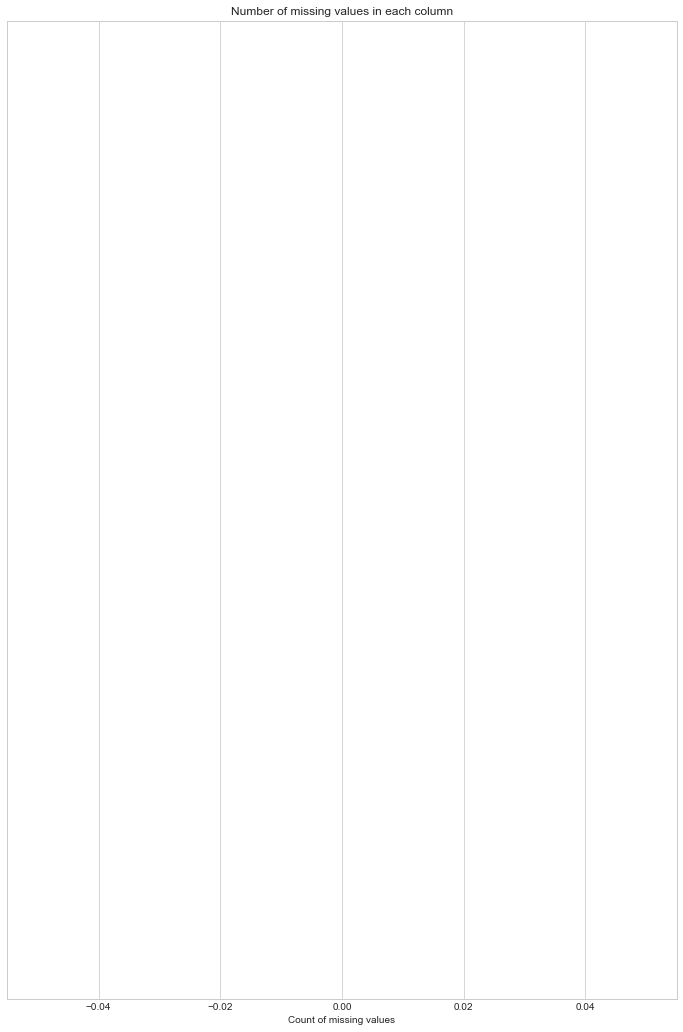

In [22]:
# Check Missing values again, after processing attempt to remove some fields and assign a value to others' NaN values
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [23]:

objs = [ 'airconditioningtypeid'
        ,'bedroomcnt'
        ,'buildingqualitytypeid'
        ,'fireplacecnt'
        ,'garagecarcnt'
        ,'heatingorsystemtypeid'
        ,'numberofstories'
        ,'poolcnt'        
        ,'propertylandusetypeid'   
        ,'regionidcounty'
        ,'unitcnt'
        ,'yearbuilt'   
        ,'taxdelinquencyflag'  
        ,'yardbuildingsqft17'
        ,'yardbuildingsqft26'        
        ]


for obj in objs:
    train_df[obj] = train_df[obj].astype(object)

In [24]:

flts = [ 'basementsqft'
        ,'calculatedbathnbr'
        ,'calculatedfinishedsquarefeet'
        ,'landtaxvaluedollarcnt'
        ,'lotsizesquarefeet'
        ,'roomcnt'
        ,'structuretaxvaluedollarcnt'
       ]

for flt in flts:
    train_df[flt] = train_df[flt].astype(float)

In [25]:
# Decide which categorical variables you want to use in model
for col in train_df.columns:
    if train_df[col].dtypes == 'object':       
        unique_cat = len(train_df[col].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col, unique_cat=unique_cat))

Feature 'airconditioningtypeid' has 7 unique categories
Feature 'bedroomcnt' has 7 unique categories
Feature 'buildingqualitytypeid' has 4 unique categories
Feature 'fireplacecnt' has 4 unique categories
Feature 'garagecarcnt' has 5 unique categories
Feature 'heatingorsystemtypeid' has 6 unique categories
Feature 'poolcnt' has 2 unique categories
Feature 'propertylandusetypeid' has 14 unique categories
Feature 'regionidcounty' has 3 unique categories
Feature 'unitcnt' has 5 unique categories
Feature 'yardbuildingsqft17' has 2 unique categories
Feature 'yardbuildingsqft26' has 2 unique categories
Feature 'yearbuilt' has 14 unique categories
Feature 'numberofstories' has 4 unique categories
Feature 'taxdelinquencyflag' has 2 unique categories


In [26]:
# Create dummy list
to_dummy = [ 'airconditioningtypeid'
            ,'bedroomcnt'
            ,'buildingqualitytypeid'
            ,'fireplacecnt'
            ,'garagecarcnt'
            ,'heatingorsystemtypeid'
            ,'numberofstories'
            ,'poolcnt'
            ,'propertylandusetypeid'   
            ,'regionidcounty'         
            ,'unitcnt'
            ,'yearbuilt'   
            ,'taxdelinquencyflag'  
            ,'yardbuildingsqft17'
            ,'yardbuildingsqft26'   
            ,'transaction_month'
            ]

In [27]:
# Use this function to dummy all the categorical variables we want to keep
def dummy_df(df, todummy_list):
    for x in todummy_list:       
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=True)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [28]:
## Transform to our training dataframe  
train_df = dummy_df(train_df, to_dummy)

In [29]:
train_df.head()

,parcelid,logerror,basementsqft,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,roomcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,roomcnt0,...,transaction_month_4.0,transaction_month_5.0,transaction_month_6.0,transaction_month_7.0,transaction_month_8.0,transaction_month_9.0,transaction_month_10.0,transaction_month_11.0,transaction_month_12.0,transaction_month_nan
0,11016594,0.0276,0.0,2.0,1684.0,7528.0,3.0,122754.0,237416.0,1,...,0,0,0,0,0,0,0,0,0,0
1,14366692,-0.1684,0.0,3.5,2263.0,3643.0,3.0,346458.0,239071.0,1,...,0,0,0,0,0,0,0,0,0,0
2,12098116,-0.0040,0.0,3.0,2217.0,11423.0,3.0,61994.0,57912.0,1,...,0,0,0,0,0,0,0,0,0,0
3,12643413,0.0218,0.0,2.0,839.0,70859.0,3.0,171518.0,73362.0,1,...,0,0,0,0,0,0,0,0,0,0
4,14432541,-0.0050,0.0,2.5,2283.0,6000.0,10.0,169574.0,264977.0,0,...,0,0,0,0,0,0,0,0,0,0


<h1> Machine Learning Start </h1>

First we'll split our data into training and development data.  We will not further split this into a test dataset, as the submission to Kaggle will test how well our model generalizes to new data.

One note: Some of the machine learning models we used below (Gradient Boost, Decision Tree, Random Forest) have a parameter for "critereon" where we could specify MAE (mean absolute error). Since the Zillow competition is scored on MAE, it would make sense, in theory, for us to set the critereon to MAE. However, in practice, setting critereon=MAE caused severe computation performance issues which resulted in either our machines crashing or the models taking hours and hours to run. For that reason, we opted to not use critereon = MAE.

In [30]:
# split data into training and dev sets.
train_np = train_df.values
Y = train_np[:,1]
Y.flatten()
X = train_np[:,2:]

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape: ', Y.shape)

# Set some variables to hold test, dev, and training data.
train_data, train_labels = X[:70000], Y[:70000]
dev_data, dev_labels = X[70000:], Y[70000:]

#definite MAE (Mean Absolute Error) function
def MAE(test_labels, predictions):
    values = []
    for i in range(len(test_labels)):
        difference = abs(round(test_labels[i],6) - round(predictions[i],6))
        values.append(difference)
    mean_abs_error = round(sum(values)/len(values),7)
    return mean_abs_error

('data shape: ', (90275, 124))
('label shape: ', (90275,))


### Create Submission Dataset

The sample submission contains 6 distinct estimates (Oct-2016, Nov-2016, Dec-2016, Oct-2017, Nov-2017, and Dec-2017) for the 2.9 million properties. Since our training data only includes transactions from 2016, it is tough for us to determine if there is a time-series component to the logerrors or if the differences are simply due to seasonality. For that reason, we decided to simply make estimated for October, November, and December regardless of year and treat any differences as though they are just due to seasonality and the same seasonality differences will occur in both 2016 and 2017.

The following code is used to simplify creating the submission file. The "preprocessed_properties.csv" file was created in a separate workbook but had identical transformations as the data above.

In [31]:
properties_df = pd.read_csv("preprocessed_properties.csv")
print(properties_df.shape)

# convert to array and remove parcelIDs
properties_np = properties_df.values
parcelids = properties_np[:, 0]
props_to_model = properties_np[:, 1:]

# function to create Kaggle submission files 
def get_submission_file(parcelids, oct_est, nov_est, dec_est):
    submission_array = np.vstack((parcelids, oct_est, nov_est, dec_est, oct_est, nov_est, dec_est))

    submission_df = pd.DataFrame(submission_array.T)
    submission_df.rename(columns={0: 'ParcelId',
                                  1: '201610',
                                  2: '201611',
                                  3: '201612',
                                  4: '201710',
                                  5: '201711',
                                  6: '201712'
                                 }, inplace=True)
    
    submission_df["ParcelId"] = submission_df["ParcelId"].astype(int)
    submission_df.to_csv("Zillow_submission_file.csv", index = False)
    
    return submission_df.head()

(2985217, 112)


In [32]:
# create arrays to represent months Oct, Nov, Dec
# note: our months are dummy variables
rows = props_to_model.shape[0]
october = np.hstack((np.zeros((rows,9)), np.ones((rows,1)), np.zeros((rows,3))))
november = np.hstack((np.zeros((rows,10)), np.ones((rows,1)), np.zeros((rows,2))))
december = np.hstack((np.zeros((rows,11)), np.ones((rows,1)), np.zeros((rows,1))))

# Create separate dataset for each month that we're trying to predict
submission_setup_oct = np.hstack((props_to_model, october))
submission_setup_nov = np.hstack((props_to_model, november))
submission_setup_dec = np.hstack((props_to_model, december))

## Linear Regression Model

Linear regression fits a "best fit" line to the linear combination of our features by minimizing the mean square error of the data.  The linear model makes multiple assumptions about our data- such as constant variance and no perfect multicollinearity among the features.  Given that our data is quite dependent- for example we would expect square footage to impact the number of rooms, number of bathrooms, and the tax value of the property- we would expect that independence of our data is quite limited and that this model will not generalize well to new information.  Despite such limitations, linear regression is a robust model and is an appropriate starting point for a baseline model.

In [33]:
# Initialize model
lm = LinearRegression()
lm.fit(train_data, train_labels)
lm_predict = lm.predict(dev_data)

lm_mae = MAE(dev_labels, lm_predict)
print("Linear Regression gives us a Mean Absolute Error of", lm_mae)

('Linear Regression gives us a Mean Absolute Error of', 0.0671205)


The linear regression model produced a mean absolute error of the log error of 0.0671205.  This is slightly worse than our test submission which estimated the sample mean of the log error for every property.

## Gradient Boosting Regression

Gradient boosting regression is a type of decision tree model, which benefits from regression by minimizing the mean square error at each step it takes from the root.  The "gradient boosting" means that instead of just performing the decision tree model once, we create an ensemble of trees.  We presume that by using an ensemble of estimators over a single estimator, we will converge upon a better and more generalizable.

In [34]:
# Due to large number of features, we'll limit these parameters to make iteration faster
estimators = [10, 50, 100] 
learning_rates = [.05, .1]
lowest_mae = 1
results = []
for i in estimators:
    for l in learning_rates:
            gboost = GradientBoostingRegressor(n_estimators=i, learning_rate= l) 
            gboost.fit(train_data, train_labels)
            gboost_predict = gboost.predict(dev_data)

            mae = MAE(dev_labels, gboost_predict)
            results.append(mae)
            print("Estimator: {}, Learning Rate: {}, MAE: {}".format(i, l, mae) )

            if mae < lowest_mae:
                lowest_mae = mae
                best_estimator = i
                best_lr = l
                
print("Best Results- Estimator: {}, Learning Rate: {},  MAE: {}".format(best_estimator, best_lr, lowest_mae) )

Estimator: 10, Learning Rate: 0.05, MAE: 0.0669479
Estimator: 10, Learning Rate: 0.1, MAE: 0.0668665
Estimator: 50, Learning Rate: 0.05, MAE: 0.0669449
Estimator: 50, Learning Rate: 0.1, MAE: 0.0669627
Estimator: 100, Learning Rate: 0.05, MAE: 0.0670405
Estimator: 100, Learning Rate: 0.1, MAE: 0.0672587
Best Results- Estimator: 10, Learning Rate: 0.1,  MAE: 0.0668665


From a model perspective, we experienced a slight improvement in MAE by changing to a gradient boosting regression model.  From a practical perspective, iterating on a dataset with 120+ features is time-consuming and leads to dimensionality problems in our dataset.  We will continue with Principal Component Analysis to reduce our dataset into a denser feature space.

# Principal Component Analysis

Principal Component Analysis (PCA) is a technique used to reduce high dimensionality data. High dimensionality data is problematic because as it acts as a multiplier to the feature space. For example, consider the area of a 10x10 coordinate system. The feature space has an area of 100 square units. If you add a z dimension of size 10 to the data, the volume becomes 1000 cubed units. Continuing to add more dimensions continues to multiply the size of the feature space which makes the data relatively sparse. This is the curse of dimensionality.
PCA combats the curse of dimensionality by finding new dimensions that reduce the dimensionality of the data while minimizing the loss of information.

('k=1, explained variance =', 0.83496692568086095)
('k=2, explained variance =', 0.94025263963456585)
('k=3, explained variance =', 0.99999797216408037)
('k=4, explained variance =', 0.99999999807990947)
('k=5, explained variance =', 0.99999999994929378)
('k=6, explained variance =', 0.99999999997312095)
('k=7, explained variance =', 0.99999999997680933)
('k=8, explained variance =', 0.99999999998006328)
('k=9, explained variance =', 0.99999999998169598)
('k=10, explained variance =', 0.99999999998311406)


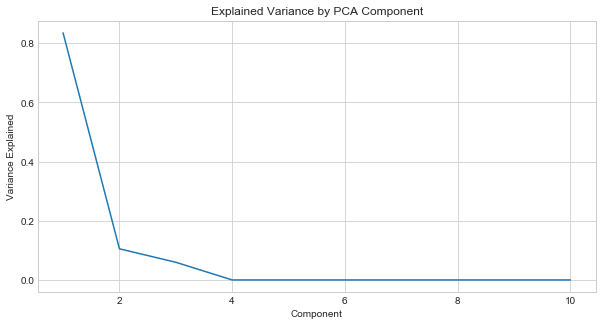

In [35]:
pca = PCA(n_components=10)
pca.fit(train_data)
for k in range(1,11):
    explained_var = pca.explained_variance_ratio_[0:k]
    var_exp_single = pca.explained_variance_ratio_
    print("k=" + str(k) + ", explained variance =", sum(explained_var))

# Plot of variance explained
plt.figure(figsize = (10,5))
plt.plot(range(1, k+1), var_exp_single[:k])
plt.ylabel("Variance Explained")
plt.xlabel("Component")
plt.title("Explained Variance by PCA Component")

We believe 3 PCA components is best to use. This gives us greater than 99.99% explained variance

Now we'll create a classifier dataframe.  We'll classifier a logerror e<-.1 as -1, e> .1 as 1, and -.1< e < .1 as 0.  We'll use this data to visualize if the PCA separates the categories.

('data shape: ', (90275, 124))
('label shape: ', (90275,))


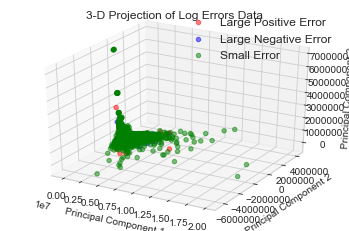

In [36]:
#Create a copy of the train_data so that we cam make changes
classifier_data = train_df.copy()
classifier_data = classifier_data.drop('parcelid', axis = 1)

classifier_data['logerror'].loc[classifier_data['logerror']>=.1] = 1
classifier_data['logerror'].loc[classifier_data['logerror']<= -.1] = -1
classifier_data['logerror'].loc[(classifier_data['logerror']>-.1) & (classifier_data['logerror']<.1)] = 0

train_np = classifier_data.values
Y = train_np[:,0]
Y.flatten()
X =train_np[:,1:]

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape: ', Y.shape)

# Set some variables to hold test, dev, and training data.
classifier_test_data, classifier_test_labels = X[70000:], Y[70000:]
classifier_train_data, classifier_train_labels = X[:70000], Y[:70000]

# Now visualize
pca = PCA(n_components=3)
pca_data = pca.fit_transform(classifier_data)

x1=pca_data[:,0][classifier_train_labels==1]
y1= pca_data[:,1][classifier_train_labels==1]
z1= pca_data[:,2][classifier_train_labels==1]

x2= pca_data[:,0][classifier_train_labels == -1]
y2=pca_data[:,1][classifier_train_labels==-1]
z2=pca_data[:,2][classifier_train_labels==-1]

x3= pca_data[:,0][classifier_train_labels==0]
y3= pca_data[:,1][classifier_train_labels==0]
z3= pca_data[:,2][classifier_train_labels==0]

#plot PCA data
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x1, y1, z1, color = 'red', label = 'Large Positive Error', alpha = .5)
ax.scatter(x2, y2, z2, color = 'blue', label = 'Large Negative Error', alpha = .5)
ax.scatter(x3, y3, z3, color = 'green', label = 'Small Error', alpha= .5)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.legend(loc="best", fontsize = 12)
plt.title("3-D Projection of Log Errors Data")


Despite capturing 99.99% of the variation, you can see that PCA does not help separate the data in 3-dimensional space.

## Gradient Boosting Regression with PCA

In [37]:
pca = PCA(n_components=3)
pca.fit(train_data)
train_data_pca = pca.transform(train_data) 
dev_data_pca = pca.transform(dev_data) 

## Best results were estimator = 39, learning rate= .1, depth= 3, loss = 'lad'
estimators = range(15, 45, 2) # Ran from 50-300, but higher estimators did not improve results
learning_rates = [0.01, .025, .05, .1] # Ran at rates of .2 and .5, but no improvement
depths = [2, 3] #Rates of 4 and 5 decreased results, so removed
loss_fncs = ["ls", "lad", "huber"]
lowest_mae = 1
results = []
for i in estimators:
    for l in learning_rates:
        for d in depths:
            for loss in loss_fncs:
                gboost = GradientBoostingRegressor(n_estimators=i, learning_rate= l, max_depth = d, loss = loss) 
                gboost.fit(train_data_pca, train_labels)
                gboost_predict = gboost.predict(dev_data_pca)

                mae = MAE(dev_labels, gboost_predict)
                results.append(mae)

                if mae < lowest_mae:
                    lowest_mae = mae
                    best_estimator = i
                    best_lr = l
                    best_depth = d
                    best_loss = loss
                
print("Best Results- Estimators: {}, Learning Rate: {}, Max Depth: {}, Loss: {}, MAE: {}"
      .format(best_estimator, best_lr, best_depth, best_loss, lowest_mae) )

Best Results- Estimators: 39, Learning Rate: 0.1, Max Depth: 3, Loss: lad, MAE: 0.0666397


In [45]:
# We'll post the results from the above into our submission model
# transform datasets 
subm_pca_oct = pca.transform(submission_setup_oct)
subm_pca_nov = pca.transform(submission_setup_nov)
subm_pca_dec = pca.transform(submission_setup_dec)

gboost = GradientBoostingRegressor(n_estimators=39, learning_rate= .1, max_depth= 3, loss = "lad") 
gboost.fit(train_data_pca, train_labels)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=41, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [46]:
# make predictions and create Kaggle submission file
pca_gboost_subm_oct = gboost.predict(subm_pca_oct)
pca_gboost_subm_nov = gboost.predict(subm_pca_nov)
pca_gboost_subm_dec = gboost.predict(subm_pca_dec)

get_submission_file(parcelids, pca_gboost_subm_oct, pca_gboost_subm_nov, pca_gboost_subm_dec)

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.015463,0.015463,0.015463,0.015463,0.015463,0.015463
1,10759547,0.002759,0.002759,0.002759,0.002759,0.002759,0.002759
2,10843547,0.025560,0.025560,0.025560,0.025560,0.025560,0.025560
3,10859147,0.013404,0.013404,0.013404,0.013404,0.013404,0.013404
4,10879947,0.003887,0.003887,0.003887,0.003887,0.003887,0.003887


# Decision Tree Regression

In [40]:
dtr = DecisionTreeRegressor()
dtr.fit(train_data_pca, train_labels)
dtr_preds = dtr.predict(dev_data_pca)
dtr_mae = MAE(dev_labels, dtr_preds)
print 'DecisionTreeRegressor MAE =', dtr_mae

DecisionTreeRegressor MAE = 0.1134992


A single decision tree does not work very well here (the Mean Absolute Error was almost twice as high as the models above). Next, let's try Random Forest to see if multiple trees help.

# Random Forest Regression

In [42]:
estimators = range(5, 56, 2) 
depths = [2, 3] 
lowest_mae = 1
results = []
for i in estimators:
    for d in depths:
        rfr = RandomForestRegressor(n_estimators=i, max_depth = d) 
        rfr.fit(train_data_pca, train_labels)
        rfr_preds = rfr.predict(dev_data_pca)

        mae = MAE(dev_labels, rfr_preds)
        results.append(mae)

        if mae < lowest_mae:
            lowest_mae = mae
            best_estimator = i
            best_depth = d
                
print("Best Results- Estimators: {}, Max Depth: {}, MAE: {}".format(best_estimator, best_depth, lowest_mae) )

Best Results- Estimators: 11, Max Depth: 2, MAE: 0.0670595


The Random Forest Regression works much better than a single decision tree, but Random Forest still performs slightly worse than the Gradient Boost Regression above. Out of all of our models, Gradient Boost worked the best, so we decided to use that for our submission to Kaggle.

## Appendix

Our group tried multiple other models for classification and point prediction that were ultimately unhelpful to our final submission.  Here, we'll share our code and thought processes on attempting these models, as well as our thoughts as to why they failed to be predictive of log error.

<h2> K-Nearest Neighbors </h2>

K-Nearest Neighbors is a classification model which predicts the classification of an unclassified data point based upon the values of it's closest k neighbors. Therefore, when k=1, the model will predict the value based upon the cloest neighbor. When k= 9, the model will find the new data points 9 closest neighbors and determine the majority classification of those nine points. The majority classification will be imputed to the unclassified data point.
Here, we are attempting to classify whether an property value will result in a large positive error, a low error, or a large negative error. By classifying the type of error, we can help direct our final model towards a specific predicted error value, thus lowering the MAE.

In [48]:
#Create a copy of the train_data so that we can make changes
classifier_data = train_df.copy()
classifier_data = classifier_data.drop('parcelid', axis = 1)

classifier_data['logerror'].loc[classifier_data['logerror']>=.1] = 1
classifier_data['logerror'].loc[classifier_data['logerror']<= -.1] = -1
classifier_data['logerror'].loc[(classifier_data['logerror']>-.1) & (classifier_data['logerror']<.1)] = 0

train_np = classifier_data.values
Y = train_np[:,0]
Y.flatten()
X =train_np[:,1:]

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape: ', Y.shape)

# Set some variables to hold test, dev, and training data.
classifier_test_data, classifier_test_labels = X[70000:], Y[70000:]
classifier_train_data, classifier_train_labels = X[:70000], Y[:70000]

data shape:  (90275, 124)
label shape:  (90275,)


In [49]:
#Originally ran with k values range (1,200,20), but little to no increase after k>20
k_values = range(10,32, 2)
for k in k_values:
    #initialize and train the classifier
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(classifier_train_data, classifier_train_labels)
    accuracy= clf.score(classifier_test_data, classifier_test_labels)
    predictions = clf.predict(classifier_test_data)
    
    #Uncomment code below and comment out if statement above to get classification report for all k values
#     print("Classification Report for k =" + str(k))
#     print(classification_report(knn_test_labels.astype(int),predictions))
# For all k values, print the accuracy
    print("K: " + str(k) + " Accuracy: " + str(accuracy))
    if k == 30:
        print("Classification Report for k = {}".format(k))
        print(classification_report(classifier_test_labels.astype(int),predictions))

K: 10 Accuracy: 0.837977805179
K: 12 Accuracy: 0.838865598027
K: 14 Accuracy: 0.838816276202
K: 16 Accuracy: 0.839112207152
K: 18 Accuracy: 0.838865598027
K: 20 Accuracy: 0.839013563502
K: 22 Accuracy: 0.839062885327
K: 24 Accuracy: 0.839161528977
K: 26 Accuracy: 0.839210850801
K: 28 Accuracy: 0.839260172626
K: 30 Accuracy: 0.839210850801
Classification Report for k = 30
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00      1374
          0       0.84      1.00      0.91     17020
          1       0.00      0.00      0.00      1881

avg / total       0.70      0.84      0.77     20275



<b>Results: </b> While the accuracy of this model in classifying whether the outcome will be a large positive error (1), a low error (0), or a large negative error(-1) is approximately 84%, this K-Nearest Neighbors classifier performance is quite poor. The printed classification report is for the k=1 model, but the reports for higher k models show the same general issues  

The precision column indicates the positive predictive value, which is calculated by the number of true positives divided by the number of true positives plus false positives.  In our situation, the precision measures the percentage of predictions that our model predicted to be 1s that were actually 1s.  As you can see, the precision of this model is low at 25% values that extreme highs and 0% for extreme lows.  This classifier performs very poorly for precision. 

The recall column indicates the sensitivity of the model.  It is calculated by taking the ratio of true positive results divided by the sum of true positives and false negatives.  In this situation, recall measures the percentage of 1s that our model identifies out of all 1s it should have identified. In our model, the recall is 0% for the extreme log errors that we are trying to classify.  

The f1-score is the weighted harmonic mean of the precision and recall and gives an understanding of the overall power of the classifier. 

Due to the relatively small amount of extreme results in our data, this classifier tends to overpredict results of 0.  As a result, we end up with high accuracy, but poor precision and recall.  Therefore, we will not add the results of this classifier into our dataset for our final model.

<h2> Naive Bayes </h2>

Naive Bayes methods are supervised learning algorithms that apply Bayes' Theorem with the assumption of independence between each pair of features.  While we know that we do not have independence between each pair of features in our data, in practice, Naive Bayes has worked well in datasets that violate this assumption.  

The SKLearn package supports three distinct Naive Bayes models.  The first is Gaussian Naive Bayes model.  This model assumes the likelihood of the features is distributed like a Gaussian, or normal, distribution.  The second supported model is the Multinomial Naive Bayes model.  The multinomial model is for multinomially distributed data and is best suited for data that can be turned into counts- such as text classification with word counts.  The final model is the Bernoulli Naive Bayes model, which is used with data distributed similar to a multivariate Bernoulli Distribution.  Each feature in a Bernoulli model is assumed to be binary.  

More information about SKLearn Naive Bayes models can be located here: http://scikit-learn.org/stable/modules/naive_bayes.html

Since our data can be best classified as normally distributed and is not binary and is not well suited for a multinomial distribution, we will use a Gaussian Naive Bayes model.

In [50]:
#Initialize model and test accuracy of multinomial naive bayes classifier
gauss_nb = GaussianNB()
gauss_nb.fit(classifier_train_data, classifier_train_labels)
nb_accuracy = gauss_nb.score(classifier_test_data, classifier_test_labels)
print("Accuracy of Gaussian Naive Bayes Model: {}".format(round(nb_accuracy,3)))

Accuracy of Gaussian Naive Bayes Model: 0.807


In [51]:
gauss_probs = gauss_nb.predict_proba(classifier_test_data)
high_neg_error = 0
low_error = 0
high_pos_error = 0

for i in range(len(gauss_probs)):
    val_array = gauss_probs[i]
    max_index = np.argmax(val_array)
    if max_index == 0:
        high_neg_error +=1
    elif max_index == 1:
        low_error +=1
    elif max_index ==2:
        high_pos_error +=1
    else:
        print("unsure")

print("Est Number High Neg Errors: {} \nEst Number Low Errors: {} \nEst Number High Pos Errors: {}".format(high_neg_error, low_error, high_pos_error))
print("Actual High Negative Errors: {} \nActual Low Errors: {} \nActual High Pos Errors: {}".format(len(classifier_test_labels[classifier_test_labels==-1]), len(classifier_test_labels[classifier_test_labels==0]), len(classifier_test_labels[classifier_test_labels==1])))

Est Number High Neg Errors: 386 
Est Number Low Errors: 19165 
Est Number High Pos Errors: 724
Actual High Negative Errors: 1374 
Actual Low Errors: 17020 
Actual High Pos Errors: 1881


In [52]:
gauss_nb.class_count_

array([  4821.,  58680.,   6499.])

In [53]:
print("Percent of low errors in test data: {:.3}".format(16992/(16992+1369+1914)))
print("Percent of low errors in training data: {:.3}".format(58708/(58708+6466+4826)))
print("Percent of low errors predicted: {:.3}".format(19239/(19239+688+348)))

Percent of low errors in test data: 0.838
Percent of low errors in training data: 0.839
Percent of low errors predicted: 0.949


The Gaussian Naive Bayes model fails in improving predicting whether a transaction will have a high positive, high negative, or low log error.  Our data are not independent and does not meet the initial assumptions of the model.  Further, the highly peaked distribution with relatively few low error points (classified as 0s) which leads to an overprediction of low error transactions- 94% predicted versus 83% in test and training data.

## K Nearest Neighbors with PCA Data

In [54]:
#Create a copy of the train_data so that we can make changes
classifier_data = train_df.copy()
classifier_data = classifier_data.drop('parcelid', axis = 1)

classifier_data['logerror'].loc[classifier_data['logerror']>=.1] = 1
classifier_data['logerror'].loc[classifier_data['logerror']<= -.1] = -1
classifier_data['logerror'].loc[(classifier_data['logerror']>-.1) & (classifier_data['logerror']<.1)] = 0

train_np = classifier_data.values
Y = train_np[:,0]
Y.flatten()
X =train_np[:,1:]

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape: ', Y.shape)

# Set some variables to hold test, dev, and training data.
classifier_test_data, classifier_test_labels = X[70000:], Y[70000:]
classifier_train_data, classifier_train_labels = X[:70000], Y[:70000]

pca = PCA(n_components=3)
pca.fit(classifier_train_data)
classifier_train_data_pca = pca.transform(classifier_train_data) 
classifier_test_data_pca = pca.transform(classifier_test_data) 


k_values = range(1,16)
for k in k_values:
    #initialize and train the classifier
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(classifier_train_data_pca, classifier_train_labels)
    accuracy= clf.score(classifier_test_data_pca, classifier_test_labels)
    predictions = clf.predict(classifier_test_data_pca)
    
    #Uncomment code below and comment out if statement above to get classification report for all k values
#     print("Classification Report for k =" + str(k))
#     print(classification_report(knn_test_labels.astype(int),predictions))
# For all k values, print the accuracy
    print("K: " + str(k) + " Accuracy: " + str(accuracy))
    if k == 15:
        print("Classification Report for k = {}".format(k))
        print(classification_report(classifier_test_labels.astype(int),predictions))

data shape:  (90275, 124)
label shape:  (90275,)
K: 1 Accuracy: 0.725819975339
K: 2 Accuracy: 0.738002466091
K: 3 Accuracy: 0.786979038224
K: 4 Accuracy: 0.811344019729
K: 5 Accuracy: 0.819531442663
K: 6 Accuracy: 0.825647348952
K: 7 Accuracy: 0.829889025894
K: 8 Accuracy: 0.832305795314
K: 9 Accuracy: 0.833094944513
K: 10 Accuracy: 0.835067817509
K: 11 Accuracy: 0.835265104809
K: 12 Accuracy: 0.835265104809
K: 13 Accuracy: 0.836004932182
K: 14 Accuracy: 0.836004932182
K: 15 Accuracy: 0.836103575832
Classification Report for k = 15
             precision    recall  f1-score   support

         -1       0.37      0.00      0.01      1438
          0       0.84      1.00      0.91     16966
          1       0.20      0.00      0.01      1871

avg / total       0.75      0.84      0.76     20275



We see no increase in predictve power of KNN when using PCA data.  Therefore, we will not use KNN in our model to attempt to classifier our results.

## Gaussian Naive Bayes with PCA Data

In [56]:
#Initialize model and test accuracy of multinomial naive bayes classifier

gauss_nb_pca = GaussianNB()
gauss_nb_pca.fit(classifier_train_data, classifier_train_labels)
nb_accuracy = gauss_nb_pca.score(classifier_test_data, classifier_test_labels)
print("Accuracy of Multinomial Naive Bayes Model: {}".format(round(nb_accuracy,3)))

Accuracy of Multinomial Naive Bayes Model: 0.806


As you can see, the Gaussian Naive Bayes provides little improvement in prediction over our original Naive Bayes model.  We will not include classificiation in our final model.